<a href="https://colab.research.google.com/github/Soniartha/My_Strategy_Trading_Soniartha/blob/main/SARIMA_GBPUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
import warnings                                     # do not disturbed mode
warnings.filterwarnings('ignore')

In [116]:
# load the packages
import numpy as np                  # vector and matrics
import pandas as pd                 # tabel and data manipulates
import matplotlib.pyplot as plt     # plots
import seaborn as sns               # more plots

from dateutil.relativedelta import relativedelta      # working with date with style  
from scipy.optimize import minimize                   # for function minimzation

import statsmodels.formula.api as smf   # stats and economy metrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product   # some useful function
from tqdm import tqdm_notebook

#importing everything for forecasting quality metrics
from sklearn.metrics import r2_score,median_absolute_error,mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

#data reader
import pandas_datareader as web

#datetime
import datetime

In [117]:
def mean_absolute_persentage_error (y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred)/ y_true)) * 100

def tsplot (y, lags=None, figsize = (12,7), style = 'bmh'):
  """
      plot time series, it ACF and PACF, calculate Dickey-Fuller test

      y - time series
      lags - how many lags to include in AFC, PAFC calculation
  """
  if not isinstance(y, pd.Series):
    y = pd.Series(y)

  with plt.style.context(style):
    fig = plt.figure(figsize = figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan= 2)
    afc_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))

    y.plot(ax = ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Plots\n Dicky-Fuller: p={0:.5f}'.format (p_value))
    smt.graphics.plot_acf(y, lags = lags, ax = afc_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax = pacf_ax)
    plt.tight_layout()

In [144]:
from pandas import read_csv

In [149]:
# Prepare the data
#df = web.DataReader('TSLA',data_source='yahoo', start = '2015-01-01', end = '2021-03-14')
df = read_csv('/content/GBPUSD_Daily_202001020000_202012310000.csv', header = 0, index_col=0, parse_dates=True, squeeze=True)
df

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
<DATE>,,,,,,,
2020-01-02,1.32090,1.32305,1.31150,1.31363,48916,0,2
2020-01-03,1.31363,1.31599,1.30532,1.30743,59795,0,2
2020-01-06,1.30781,1.31741,1.30625,1.31682,50184,0,2
2020-01-07,1.31684,1.32119,1.30948,1.31203,55737,0,0
2020-01-08,1.31180,1.31694,1.30801,1.30938,65260,0,0
...,...,...,...,...,...,...,...
2020-12-24,1.34908,1.36193,1.34876,1.35336,69180,0,0
2020-12-28,1.35441,1.35762,1.34293,1.34511,74871,0,0
2020-12-29,1.34507,1.35225,1.34392,1.35003,87063,0,0


In [155]:
df_close = df.filter(['<CLOSE>'])
df_volume = df.filter(['<TICKVOL>'])
df_close, df_volume

(            <CLOSE>
 <DATE>             
 2020-01-02  1.31363
 2020-01-03  1.30743
 2020-01-06  1.31682
 2020-01-07  1.31203
 2020-01-08  1.30938
 ...             ...
 2020-12-24  1.35336
 2020-12-28  1.34511
 2020-12-29  1.35003
 2020-12-30  1.36237
 2020-12-31  1.36745
 
 [260 rows x 1 columns],             <TICKVOL>
 <DATE>               
 2020-01-02      48916
 2020-01-03      59795
 2020-01-06      50184
 2020-01-07      55737
 2020-01-08      65260
 ...               ...
 2020-12-24      69180
 2020-12-28      74871
 2020-12-29      87063
 2020-12-30      86197
 2020-12-31      83170
 
 [260 rows x 1 columns])

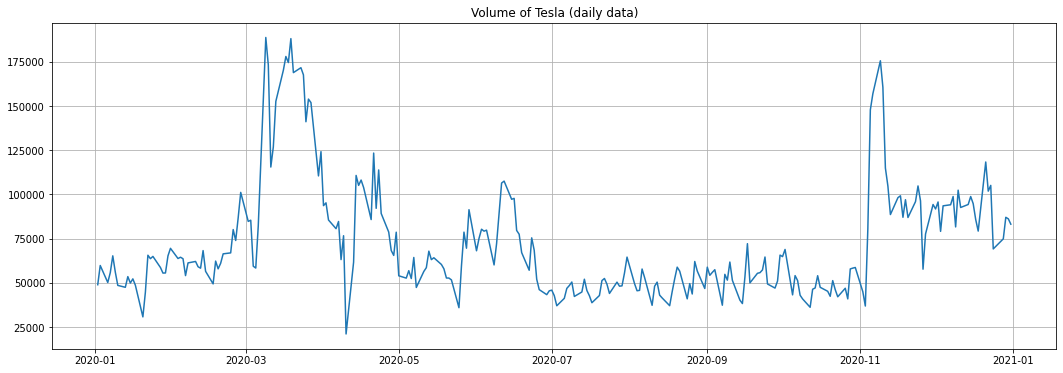

In [156]:
# Plot time series data
# ACF and PACF function will be very useful for estimate the ARMA parameters, keep in mid
plt.figure(figsize=(18,6))
plt.plot(df_volume['<TICKVOL>'])
plt.title('Volume of Tesla (daily data)')
plt.grid(True)
plt.show()

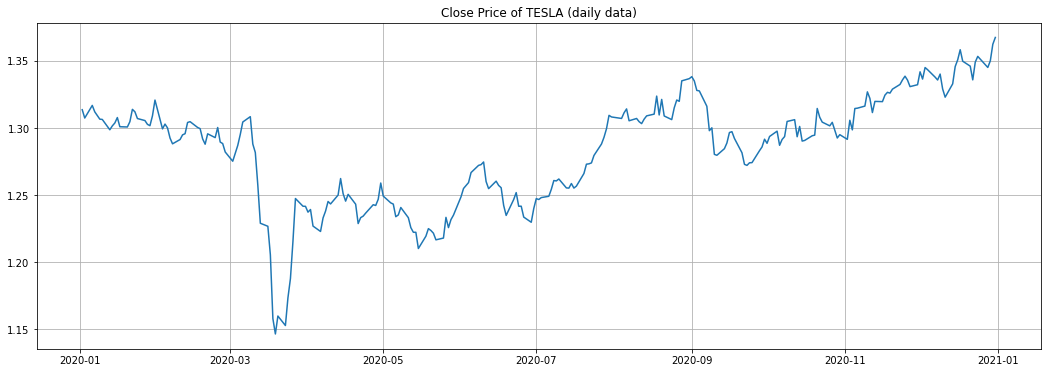

In [157]:
plt.figure(figsize=(18,6))
plt.plot(df_close['<CLOSE>'])
plt.title('Close Price of TESLA (daily data)')
plt.grid(True)
plt.show()

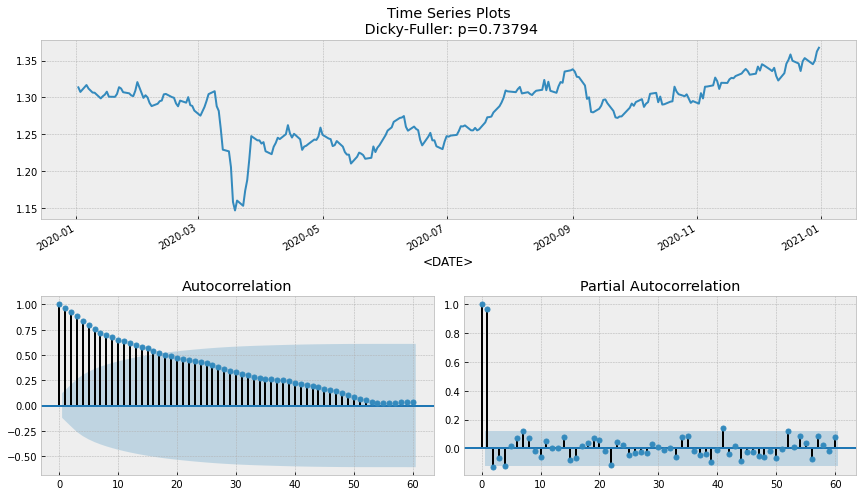

In [158]:
tsplot(df_close['<CLOSE>'], lags = 60)

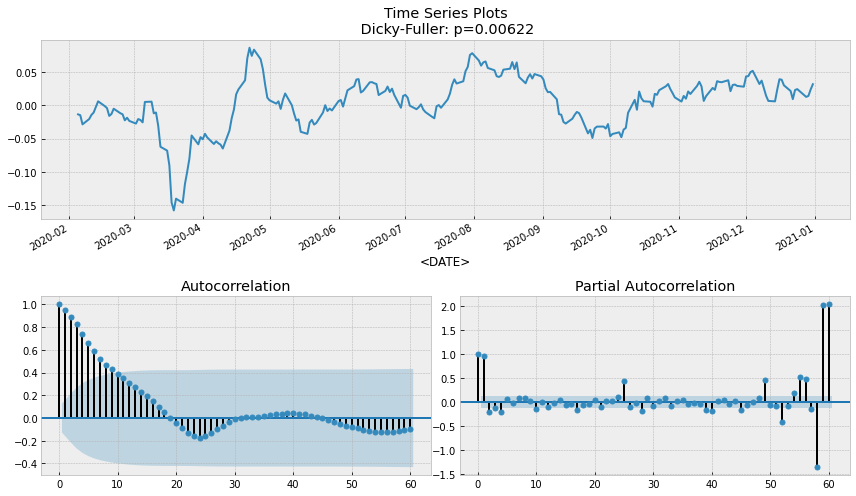

In [159]:
#The seasonal difference
close_diff = df_close['<CLOSE>'] - df_close['<CLOSE>'].shift(24)
tsplot(close_diff[24:], lags = 60) 

#SARIMA PARAMETER

1.   p is most probably 4 since it is the last significant lag on the **PACF** , after which most other are not significabt

2.   d equals 1 because we had first difference
3.   q shuld be somewhere around 4 as well as seen on the ACF
4.   P might be 2m seince 24-TH and 48-th lags are somewhat significant on the PACF
5. D again equals 1 because we performed seasonal differentiation
6.  Q is probably 1. The 14 th lag on ACF is significant whilse the 48-th in not





In [160]:
# setting initial value and some bounds for them
ps = range(2,5)
d = 1
qs = range (2,5)
Ps = range (0,2)
D = 1
Qs = range (0,2)
s = 24 #season length in still 24

# Creating list wiht all possible combination fo parameters
parameters = product (ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [161]:
def optimizeSARIMA (y, parameters_list, d, D, s):
  """ Return dataframe with parameter and corresponding AIC
  y - timeseries
  parameter_list - list with (p, q, P, Q) tuples
  d - integration order in ARIMA model
  D - seasonal integraion order
  s - length of season
  """

  result = []
  best_aic = float('inf')

  for param in  tqdm_notebook(parameters_list):
    #we need try-expect because on some combination models fail to converbe 
    try:
      model = sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), seasonal_order = (param[2], D, param[3],s )).fit(disp=-1)
    except:
      continue
    aic = model.aic
    #saving best model, AIC and parametes
    if aic < best_aic:
      best_model = model
      best_aic = aic
      best_param = param
    result.append([param, model.aic])
  
  result_table = pd.DataFrame(result)
  result_table.columns = ['parameter', 'aic']
  #sorting in ascending order, the lower aic is - the better
  result_table = result_table.sort_values(by = 'aic', ascending = True). reset_index(drop = True)

  return result_table

In [163]:
%%time
warnings.filterwarnings('ignore')
result_table = optimizeSARIMA(df_close['<CLOSE>'], parameters_list, d, D, s)


CPU times: user 9min 49s, sys: 7min 6s, total: 16min 55s
Wall time: 8min 37s


In [164]:
result_table.head()

,parameter,aic
0,"(3, 4, 0, 1)",-1504.354982
1,"(3, 4, 1, 1)",-1503.994895
2,"(4, 4, 0, 1)",-1503.908973
3,"(3, 3, 0, 1)",-1503.824004
4,"(2, 3, 0, 1)",-1503.331822


In [166]:
#set the parameter thatt give the lowest AIC
p, q, P, Q = result_table.parameter[0]

best_model = sm.tsa.statespace.SARIMAX(df_close['<CLOSE>'], order=(p,d,q), seasonal_order= (P, D, Q, s)). fit(display=-1) 

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            <CLOSE>   No. Observations:                  260
Model:             SARIMAX(3, 1, 4)x(0, 1, 1, 24)   Log Likelihood                 761.177
Date:                            Sat, 10 Apr 2021   AIC                          -1504.355
Time:                                    17:56:58   BIC                          -1473.219
Sample:                                         0   HQIC                         -1491.802
                                            - 260                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7432      0.365      2.037      0.042       0.028       1.458
ar.L2          0.1420      0.441   

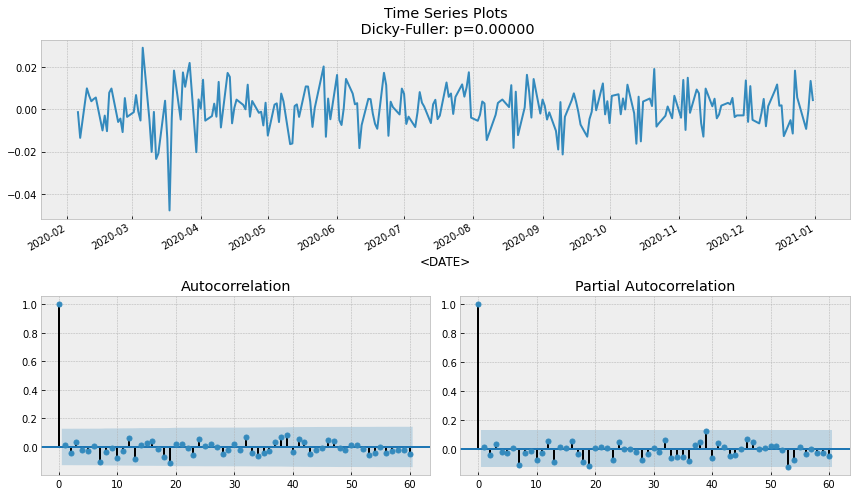

In [167]:
tsplot(best_model.resid[24+1:], lags = 60)

In [168]:
from pandas import DataFrame
from pandas import datetime

In [169]:
def plotSARIMA (series, model, n_steps):
  """ Plots model vs predicted values

      series - dataset with timeseries
      model - fitted SARIMA model
      n_steps - number of steps to predict int the future
  """

  #adding model values
  data = series.copy()
  data.columns = ['actual']
  data['sarima_model'] = model.fittedvalues
  #making a shift on s+d steps, because these values were unobserved by the model
  #due to the differentiating
  data['sarima_model'][:s+d] = np.NaN

  #forecasting on n_steps forward
  forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
  forecast = data.sarima_model.append(forecast)
  dataframe = DataFrame(forecast)
  
  #calculate error, again having shifted on s+d steps from the begining
  error = mean_absolute_persentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

  
  #calculate error, again having shifted on s+d steps from the begining
  error = mean_absolute_persentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

  plt.figure(figsize=(15,7))
  plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
  plt.plot(forecast, color = 'r', label = 'model')
  plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
  plt.plot(data.actual, label = 'actual')
  plt.legend()
  plt.grid(True)

In [170]:
dam = df_close.copy()
dam.columns = ['actual']
dam['sarima-models'] = best_model.fittedvalues
dam['sarima-models'][:s+d] = np.NaN
dam


,actual,sarima-models
<DATE>,,
2020-01-02,1.31363,NaN
2020-01-03,1.30743,NaN
2020-01-06,1.31682,NaN
2020-01-07,1.31203,NaN
2020-01-08,1.30938,NaN
...,...,...
2020-12-24,1.35336,1.347726
2020-12-28,1.34511,1.354385
2020-12-29,1.35003,1.350416


In [171]:
import pandas as pd
from pandas import datetime

#forecast on n_steps forward
steps = 20
forecast1 = best_model.predict(start=dam.shape[0]-1, end = dam.shape[0]+steps-1)
forecast1.values

array([1.36305261, 1.36666833, 1.37308606, 1.37233573, 1.37103882,
       1.36864142, 1.36717984, 1.36713931, 1.36524153, 1.36790724,
       1.36531501, 1.35976001, 1.36175811, 1.36424005, 1.36456497,
       1.36708725, 1.36676299, 1.36870561, 1.37110813, 1.37360859,
       1.37419818])

In [176]:
idx = pd.date_range('2020-12-31', periods=steps+1, freq='d')
series = pd.Series(forecast1.values, index=idx)
series = DataFrame(series)
series.columns = ['Predicted']
series

,Predicted
2020-12-31,1.363053
2021-01-01,1.366668
2021-01-02,1.373086
2021-01-03,1.372336
2021-01-04,1.371039
2021-01-05,1.368641
2021-01-06,1.367180
2021-01-07,1.367139
2021-01-08,1.365242
2021-01-09,1.367907


In [177]:
# Uji validasi model prediksi dengan data baru
val_df = web.DataReader('GBPUSD=X',data_source='yahoo', start = '2020-12-31', end = '2021-01-20')
val_df = val_df.filter(['Close'])
upsampled = val_df.resample('D').mean()
interpolated = upsampled.interpolate(method='pad')
series['Actual'] = interpolated
series

,Predicted,Actual
2020-12-31,1.363053,1.363066
2021-01-01,1.366668,1.367301
2021-01-02,1.373086,1.367301
2021-01-03,1.372336,1.367301
2021-01-04,1.371039,1.368420
2021-01-05,1.368641,1.357160
2021-01-06,1.367180,1.362955
2021-01-07,1.367139,1.362528
2021-01-08,1.365242,1.356963
2021-01-09,1.367907,1.356963


In [178]:
MAPE = mean_absolute_persentage_error(series['Predicted'], series['Actual'])

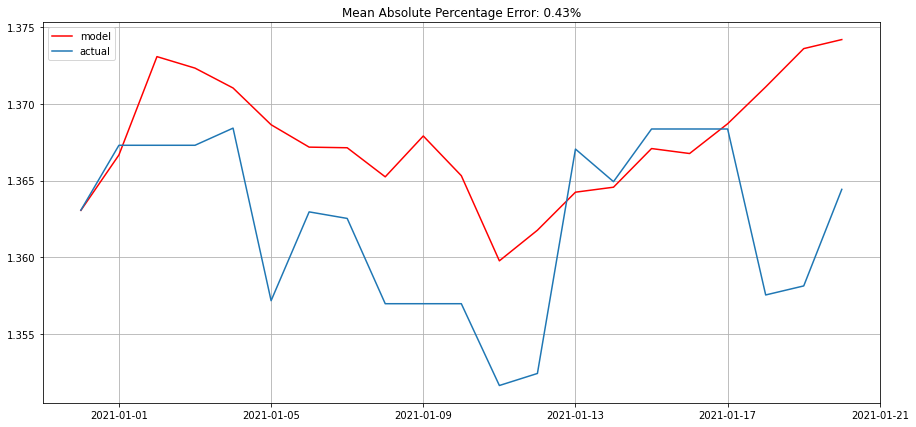

In [179]:
plt.figure(figsize=(15,7))
plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(MAPE))
#plt.plot(df_close,label='training data')
plt.plot(series.Predicted, color = 'r', label = 'model')
#plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(series.Actual, label = 'actual')
plt.legend()
plt.grid(True)

In [ ]:
"""
date = pd.date_range('2021-03-13',periods=steps)
forecast2 = [date,forecast1]
forecast2_1 = DataFrame(date)
forecast2_1.columns = ['Date']
forecast2_1['Forecast'] = forecast1
forecast2_1
forecast2= pd.datetime('2020')
forecast1 = dam.sarima_model.append(forecast1)
"""

In [ ]:
fore = best_model.predict(2000,2003)
fore = df_close['Close'].append(fore)

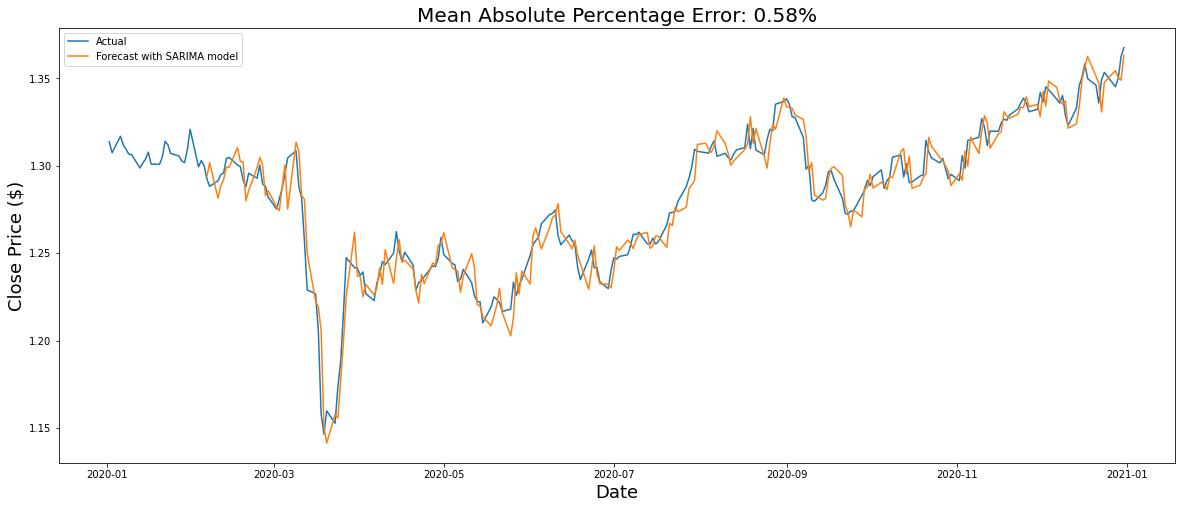

In [175]:
#adding model values
dap = df_close.copy()
dap.columns = ['actual']
dap['sarima_model'] = best_model.fittedvalues
#making a shift on s+d steps, because these values were unobserved by the model
#due to the differentiating
dap['sarima_model'][:s+d] = np.NaN

#forecasting on n_steps forward
#forecast = best_model.predict(start = df_close.shape[0], end = df_close.shape[0]+10)
#forecast = df_close.sarima_model.append(forecast)
#forecast
#dataframe = DataFrame(forecast)

error = mean_absolute_persentage_error(dap['actual'][s+d:], dap['sarima_model'][s+d:])


plt.figure(figsize=(20,8))
plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error), fontsize = 20)
plt.plot(dap.actual, label = 'Actual')
plt.plot(dap.sarima_model, label = 'Forecast with SARIMA model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price ($)', fontsize=18)
plt.legend()
plt.show()

